# Анализ журнала обнаружения вторжений (Intrusion detection log analysis)

Данный датасет содержит синтетические логи работы сети, симулирующие нормальную и вредоносную активность за недельный период.

Главные цели данного исследования:
- классифицировать запросы на обычные и вредоносные;
- классифицировать тип вредоносного запроса: сканирование портов или бот-атака.

Задачи:
- провести разведочный анализ данных;
- при необходимости очистить данные, преобразовать и создать новые параметры;
- разделить данные на тренировочную и тестовую выборки (при необходимости провести кросс-валидацию);
- на основе имеющихся данных выбрать один или несколько алгоритмов;
- выбрать гиперпараметры для алгоритмов;
- обучить модели на тренировочных данных;
- оценить качество моделей, выбрать среди них наиболее хорошо обобщающую новые данные;
- выпить чашечку чая и завершить свой первый ML-проект на GitHub.


Ссылка: https://www.kaggle.com/datasets/developerghost/intrusion-detection-logs-normal-bot-scan

This dataset contains realistic synthetic network logs simulating both normal and malicious activity over a one-week period.

The main goals of this research are:
- classify requests by common and malicious;
- classify the type of malicious request: port scanning or attack of bots.

Tasks:
- perform exploratory data analysis (EDA);
- if it necessary, clear the data, transform and create new features (Feature engineering);
- split the data into training and test samples;
- based on the data choose one or more algorythms;
- choose hyperparameters for algorythms;
- train chosen models on training data;
- estimate model's quality, choose model that generalizes best for new data;
- drink a cup of tea and complete my first ML-project on GitHub.

Link: https://www.kaggle.com/datasets/developerghost/intrusion-detection-logs-normal-bot-scan

## Импорт библиотек и модулей (Importing libraries and modules)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Загрузка данных (Uploading the data)

In [2]:
logs = pd.read_csv("Network_logs.csv")
print(f"Первые 5 строк датасета:\n\n{logs.head()}\n")
print(f"Последние 5 строк датасета:\n\n{logs.tail()}")

Первые 5 строк датасета:

        Source_IP  Destination_IP  Port Request_Type Protocol  Payload_Size  \
0  192.168.142.55   42.156.67.167    80          FTP      UDP          2369   
1    53.39.165.18   94.60.242.119   135         SMTP      UDP          1536   
2  192.168.127.91      7.10.192.3    21         SMTP      TCP          1183   
3   192.168.30.40  130.169.82.211    25        HTTPS      TCP           666   
4  192.168.43.179  35.140.102.220    22          FTP      TCP          2821   

    User_Agent   Status  Intrusion  Scan_Type  
0  curl/7.68.0  Success          0     Normal  
1  Wget/1.20.3  Failure          1  BotAttack  
2  Wget/1.20.3  Success          0     Normal  
3  Mozilla/5.0  Success          0     Normal  
4  Mozilla/5.0  Success          0     Normal  

Последние 5 строк датасета:

            Source_IP   Destination_IP   Port Request_Type Protocol  \
8841   192.168.62.111    217.201.54.87     22          DNS      UDP   
8842   192.168.154.70    11.93.131.139 

## Разведочный анализ данных (Exploratory Data Analysis)
Датасет имеет 8846 строк и 10 столбцов с отсутствующими null-значениями, что несколько упрощает очистку датасета. Имеются следующие столбцы:
- Source_IP - IP-адрес источника запроса;
- Destination_IP - IP-адрес получателя запроса;
- Port - Порт;
- Request_Type - Протокол прикладного уровня;
- Protocol - Протокол нижестоящих уровней (Транспортный/сетевой);
- Payload_Size - Нагрузка;
- User_Agent - User-Agent отправителя;
- Status - Статус запроса (Успех/Провал);
- Intrussion - Отметка попытки вторжения;
- Scan_Type - Совершаемое действие (Обычное/Сканирование портов/Атака ботов)

In [12]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8846 entries, 0 to 8845
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Source_IP       8846 non-null   object
 1   Destination_IP  8846 non-null   object
 2   Port            8846 non-null   int64 
 3   Request_Type    8846 non-null   object
 4   Protocol        8846 non-null   object
 5   Payload_Size    8846 non-null   int64 
 6   User_Agent      8846 non-null   object
 7   Status          8846 non-null   object
 8   Intrusion       8846 non-null   int64 
 9   Scan_Type       8846 non-null   object
dtypes: int64(3), object(7)
memory usage: 691.2+ KB


Целевыми переменными в данном случае являются:
- Intrusion - категориальная переменная, указывающая на является ли запрос нормальным (0) или вредоносным (1);
- Scan_Type - категориальная переменная, классифицирующая тип атаки.

Посмотрим на соотношение обычных и вредоносных запросов, на количество успешных и провальных запросов, а также на количество успешных и провальных среди обычных запросов и вредоносных запросов. 

In [35]:
intrusion_counts = logs['Intrusion'].value_counts()
status_counts = logs['Status'].value_counts()

intrusion_statuses = pd.DataFrame()

for i, col_name in enumerate(['Common', 'Malicious']):
    col = logs[(logs['Intrusion'] == i) & ((logs['Status'] == 'Success') | (logs['Status'] == 'Failure'))]
    intrusion_statuses.insert(i, col_name, col['Status'].value_counts())
    
print(f"Соотношение обычных и вредоносных запросов:\n{intrusion_counts}\n")
print(f"Соотношение успешных и провальных запросов:\n{status_counts}\n")
print(f"Соотношение успешных и провальных обычных запросов:\n{intrusion_statuses['Common']}\n")
print(f"Соотношение успешных и провальных вредоносных запросов:\n{intrusion_statuses['Malicious']}\n")

Соотношение обычных и вредоносных запросов:
0    8000
1     846
Name: Intrusion, dtype: int64

Соотношение успешных и провальных запросов:
Success    7737
Failure    1109
Name: Status, dtype: int64

Соотношение успешных и провальных обычных запросов:
Success    7615
Failure     385
Name: Common, dtype: int64

Соотношение успешных и провальных вредоносных запросов:
Success    122
Failure    724
Name: Malicious, dtype: int64



В результате видим, что из всего количества запросов:
- 8000 (90,44%) являются обычными;
- 846 (9,56%) запросов являются вредоносными;
- 7737 (87,46%) являются успешными;
- 1109 (12,54%) являются провальными.

Среди обычных запросов:
- 7615 (95,19%) являются успешными;
- 385 (4,81%) являются провальными.

Среди вредоносных запросов:
- 122 (14,42%) являются успешными;
- 724 (85,58%) являются провальными.

Какие выводы мы модет из этого сделать:
- Среди обычных запросов большая часть являются успешными, а среди  вредоносных, наооборот, больше провальных запросов.
- Можно предположить, что признак "Status" можно использовать для нашей модели.

Построим столбчатую диаграмму для визуализации полученных соотношений.

Build bar chart to visualize the ratio of common and malicious requests.

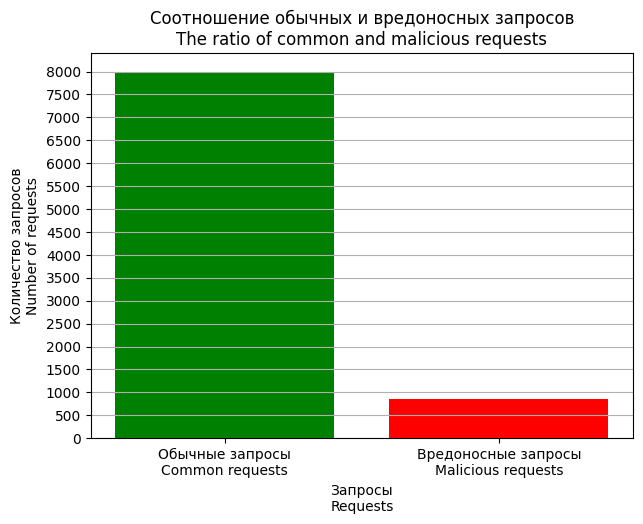

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

ax.bar(['Обычные запросы\nCommon requests', 'Вредоносные запросы\nMalicious requests'], intrusion_counts, 
          color=['g', 'r'])
ax.set_yticks(np.arange(0, np.max(intrusion_counts)+500, 500))
ax.set_title('Соотношение обычных и вредоносных запросов\nThe ratio of common and malicious requests')
ax.set_xlabel('Запросы\nRequests')
ax.set_ylabel('Количество запросов\nNumber of requests')
ax.grid(axis='y')

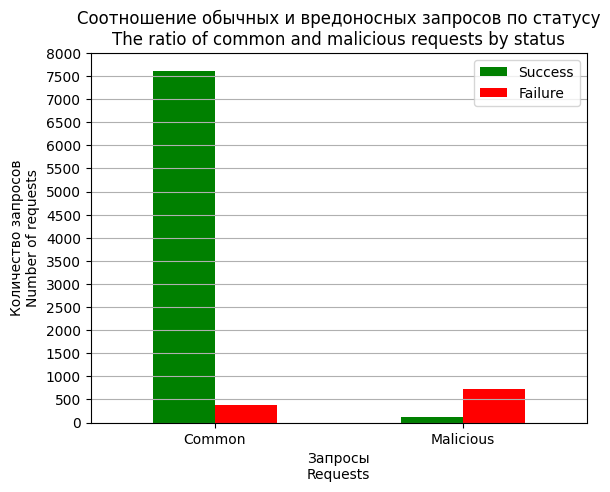

In [5]:
ax = intrusion_statuses.T.plot.bar(rot=0, color=['g', 'r'])
ax.set_title('Соотношение обычных и вредоносных запросов по статусу\nThe ratio of common and malicious requests by status')
ax.set_xlabel('Запросы\nRequests')
ax.set_ylabel('Количество запросов\nNumber of requests')
ax.set_yticks(np.arange(0, np.max(intrusion_counts)+500, 500))
ax.grid(axis='y')

Проанализируем IP-адреса отправителей и получателей.

Сами по себе IP-адреса отправителей не являются ценным признаком по следующим причинам:
- IP-адрес является просто идентификатором устройства в сети, его случайное значение никак не влияет на признак и характер атаки;
- IP-адрес атакующего устройства может быть абсолютно любым;
- IP-адреса можно менять.

По этим причинам нет смысла включать 'Source_IP' в список признаков.

IP-адреса получателей так же не является полезным признаком:
- Атаки могут происходить на разные ресурсы;
- IP-адрес не даёт информации о характере атаки и не может быть использован для прогнозирования;
- Единственной полезной информацией может быть количество атак на определённые ресурсы.

In [112]:
for i in [0, 1]:
    print(f"Количество запросов по IP-адресам с Intrusion={i}:\n{logs[logs['Intrusion']==i]['Source_IP'].value_counts().head(10)}\n")

Количество запросов по IP-адресам с Intrusion=0:
192.168.108.150    3
192.168.91.48      3
192.168.147.188    3
192.168.124.233    3
192.168.86.173     3
192.168.50.207     3
192.168.166.28     3
192.168.231.128    3
192.168.224.142    3
192.168.33.4       3
Name: Source_IP, dtype: int64

Количество запросов по IP-адресам с Intrusion=1:
33.5.52.172        58
154.113.2.100      57
95.139.88.51       57
78.199.98.120      56
197.134.233.238    54
94.40.34.8         48
201.232.85.16      46
216.181.134.4      46
161.77.134.239     45
219.110.174.163    44
Name: Source_IP, dtype: int64



In [115]:
print(f"Наиболее атакуемые ресурсы:\n{logs[logs['Intrusion']==1]['Destination_IP'].value_counts().head(20)}")

Наиболее атакуемые ресурсы:
94.60.242.119      1
80.31.151.130      1
27.59.164.247      1
137.123.118.208    1
177.60.235.115     1
133.77.244.237     1
140.2.240.109      1
102.188.236.15     1
222.197.208.212    1
214.37.2.234       1
11.190.207.68      1
188.233.35.220     1
154.110.214.184    1
177.180.3.211      1
215.85.180.167     1
178.236.92.228     1
183.231.39.110     1
203.211.7.151      1
66.88.75.41        1
220.63.190.53      1
Name: Destination_IP, dtype: int64


Как видно, среди адресов назначения не выделяются конкретные IP-адреса, следовательно данный столбец так же не несёт полезной информации.
Оба столбца можно исключить из набора признаков.

Построим гистограмму частот для визуализации размеров нагрузки с попытками вторжения. Что мы можем видеть на гистограмме:
- больше всего попыток вторжений при малом размере нагрузки;
- начиная со значения размера нагрузки в 3000 ед. все запросы являются вредоносными.

Text(0, 0.5, 'Количество запросов\nNumber of requests')

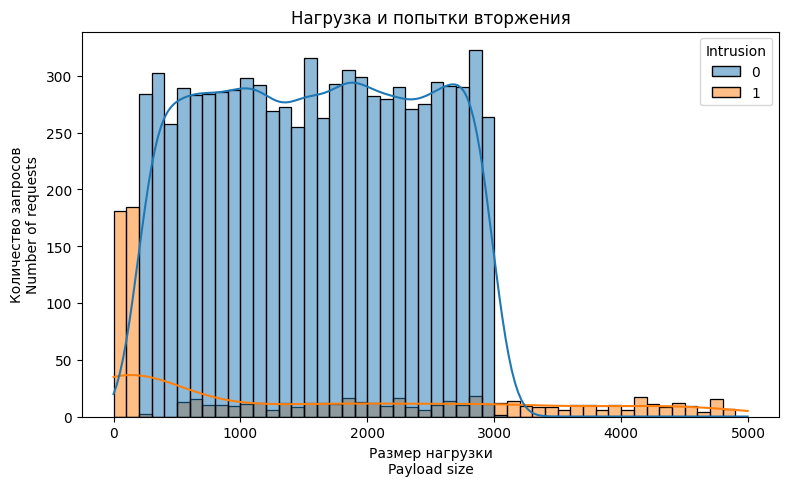

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 5))

sns.histplot(data=logs, x='Payload_Size', hue='Intrusion', bins=np.arange(0, np.max(logs['Payload_Size']), 100), kde=True, ax=ax)
ax.set_title('Нагрузка и попытки вторжения')
ax.set_xlabel('Размер нагрузки\nPayload size')
ax.set_ylabel('Количество запросов\nNumber of requests')

Построим гистограмму частот для визуализации размеров нагрузки с типом запроса. Что мы можем видеть на гистограмме:
- больше всего запросов с малой нагрузкой относятся к сканированию портов (корреляция с признаком вторжения);
- начиная со значения размера нагрузки в 3000 ед. все запросы относятся к бот-атаке (так же корреляция с признаком вторжения).

Text(0, 0.5, 'Количество запросов\nNumber of requests')

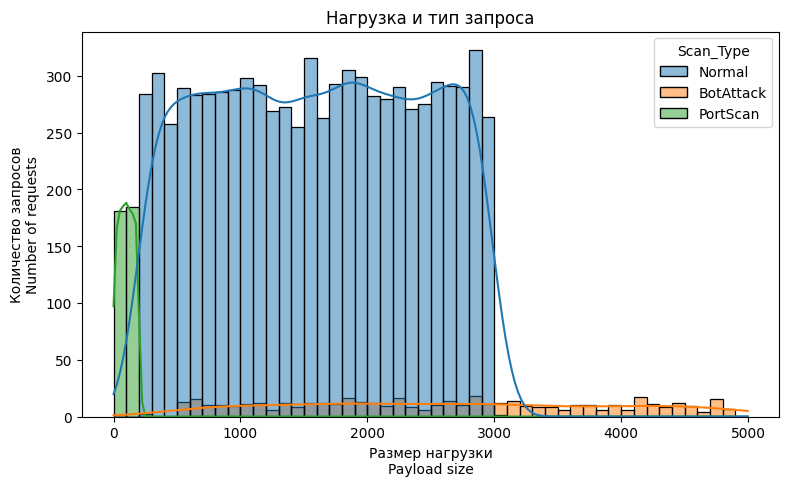

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 5))

sns.histplot(data=logs, x='Payload_Size', hue='Scan_Type', bins=np.arange(0, np.max(logs['Payload_Size']), 100), kde=True, ax=ax)
ax.set_title('Нагрузка и тип запроса')
ax.set_xlabel('Размер нагрузки\nPayload size')
ax.set_ylabel('Количество запросов\nNumber of requests')